In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt, cm

from mpl_toolkits.mplot3d import Axes3D
from numba import cuda
from numba import *


In [2]:
def plot_contour(x, y, p, u, v):
    fig = plt.figure(figsize = (11, 7), dpi = 100)
    X, Y = np.meshgrid(x, y)
    
    #Velocity field
    plt.quiver(X[::5, ::5], Y[::5, ::5], u[::5, ::5], v[::5, ::5])
    
    plt.xlabel('X')
    plt.ylabel('Y');

In [3]:
@jit(parallel = True, cache = True)
def buildB(b, rho, dt, u, v, dx, dy):
    dy2 = dy**2
    dx2 = dx**2
    dx2y2 = dy2 * dx2 
    sumdx2y2 = dy2 + dx2
    b[1:-1,1:-1] = dx2y2 / (2 * (sumdx2y2)) * (rho * (1 / dt *
                   ((u[1:-1,2:] - u[1:-1,0:-2]) / (2 * dx) +
                    (v[2:,1:-1] - v[0:-2,1:-1]) / (2 * dy)) -
                     ((u[1:-1,2:] - u[1:-1,0:-2]) / (2 * dx))**2 -
                       2 * ((u[2:,1:-1] - u[0:-2,1:-1]) / (2 * dy) *
                            (v[1:-1,2:] - v[1:-1,0:-2]) / (2 * dx)) -
                          ((v[2:,1:-1] - v[0:-2,1:-1]) / (2 * dy))**2))
    
    #periodic BC pressure @x = 2
    b[1:-1,-1] = dx2y2 / (2 * (sumdx2y2)) * (rho * (1 / dt *
                   ((u[1:-1,0] - u[1:-1,-2]) / (2 * dx) +
                    (v[2:,-1] - v[0:-2,-1]) / (2 * dy)) -
                     ((u[1:-1,0] - u[1:-1,-2]) / (2 * dx))**2 -
                       2 * ((u[2:,-1] - u[0:-2,-1]) / (2 * dy) *
                            (v[1:-1,0] - v[1:-1,-2]) / (2 * dx)) -
                          ((v[2:,-1] - v[0:-2,-1]) / (2 * dy))**2))
    
    # Periodic BC Pressure @ x = 0
    b[1:-1,0] = dx2y2 / (2 * (sumdx2y2)) * (rho * (1 / dt *
                   ((u[1:-1,1] - u[1:-1,-14]) / (2 * dx) +
                    (v[2:,0] - v[0:-2,0]) / (2 * dy)) -
                     ((u[1:-1,1] - u[1:-1,-1]) / (2 * dx))**2 -
                       2 * ((u[2:,0] - u[0:-2,0]) / (2 * dy) *
                            (v[1:-1,1] - v[1:-1,-1]) / (2 * dx)) -
                          ((v[2:,0] - v[0:-2,0]) / (2 * dy))**2))
    
    return b

In [4]:
cuda.detect()

Found 1 CUDA devices
id 0    b'NVIDIA GeForce 940MX'                              [SUPPORTED]
                      compute capability: 5.0
                           pci device id: 0
                              pci bus id: 1
Summary:
	1/1 devices are supported


True

In [5]:
def pfunc(pnx1, pnxm1, pny1, pnym1, bxy, dx2, dy2, sumdx2dy2):
    pxy = (((pnx1 + pnxm1) * dy2 +
            (pny1 + pnym1) * dx2 ) /
          (2 * sumdx2dy2)) - b
    return pxy

In [6]:
pgpu = cuda.jit(device = True)(pfunc)

In [7]:
@cuda.jit('void(float32[:,:], float32[:,:], float32[:,:], float32, float32)')
def pres_poisson(p, pn, b, dx, dy):
    dy2 = dy**2
    dx2 = dx**2
    sumdx2dy2 = dy2 + dx
    height = p.shape[0]
    width = p.shape[1]
    
    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x;
    gridY = cuda.gridDim.y * cuda.blockDim.y;
    for i in range(50):
        pn = p
        for x in range((startX + 1) , (width - 1), gridX):
            for y in range((startY + 1), (height - 1), gridY):
                p[y,x] = (((pn[y,(x+1)] + pn[y,(x-1)]) * dy2 +
                (pn[(y+1),x] + pn[(y-1),x]) * dx2 ) /
                (2 * sumdx2dy2)) - b[y,x]
        
            # Wall BC pressure
            p[0,x] = p[1,x]     # dp/dy = 0 at y = 0
            p[-1,x] = p[-2,x]   # dp/dy = 0 at y = 
        # Periodic BC pressure @ x = 2
        for y in range((startY), (height), gridY):
            p[y,-1] = (((pn[y,0] + pn[y,-2]) * dy2 +
                           (pn[(y+1),-1] + pn[(y-1),-1]) * dx2) / 
                          (2 * (sumdx2dy2)) - b[y,-1])
            p[y,0] = (((pn[y,1] + pn[y,-1]) * dy2 +
                          (pn[(y+1),0] + pn[(y-1),0]) * dx2) /
                         (2 * (sumdx2dy2)) - b[y,0])
       
            


In [8]:

def channel_flow(udiff_target,F, u, v, dt, dx, dy, p, b, rho, nu):
    udiff = 10
    stepcount = 0
    un = np.empty_like(u)
    vn = np.empty_like(v)
    pn = np.empty_like(p)
    #b = np.zeros((ny, nx))
    
    dtx = dt / dx
    dty = dt / dy
    dtx2 = dt / dx**2
    dty2 = dt / dy**2
    
    while udiff > udiff_target:
        un = u.copy()
        vn = v.copy()
        
        b = buildB(b, rho, dt, u, v, dx, dy)
        blockdim = (9,9)
        griddim = (11, 11)
        
        d_b = cuda.to_device(b)
        d_p = cuda.to_device(p)
        d_pn = cuda.to_device(pn)
        pres_poisson[griddim, blockdim](p, pn, b, dx, dy)
        d_b.to_host()
        d_p.to_host()
        d_pn.to_host()
        
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dtx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dty *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dtx / (2 * rho) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dtx2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dty2*
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])) +
                        F * dt)

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dtx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dty *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dty / (2 * rho) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dtx2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dty2*
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        # Periodic BC u @ x = 2     
        u[1:-1, -1] = (un[1:-1, -1] - un[1:-1, -1] * dt / dx * 
                      (un[1:-1, -1] - un[1:-1, -2]) -
                       vn[1:-1, -1] * dt / dy * 
                      (un[1:-1, -1] - un[0:-2, -1]) -
                       dt / (2 * rho * dx) *
                      (p[1:-1, 0] - p[1:-1, -2]) + 
                       nu * (dt / dx**2 * 
                      (un[1:-1, 0] - 2 * un[1:-1,-1] + un[1:-1, -2]) +
                       dt / dy**2 * 
                      (un[2:, -1] - 2 * un[1:-1, -1] + un[0:-2, -1])) + F * dt)

        # Periodic BC u @ x = 0
        u[1:-1, 0] = (un[1:-1, 0] - un[1:-1, 0] * dt / dx *
                     (un[1:-1, 0] - un[1:-1, -1]) -
                      vn[1:-1, 0] * dt / dy * 
                     (un[1:-1, 0] - un[0:-2, 0]) - 
                      dt / (2 * rho * dx) * 
                     (p[1:-1, 1] - p[1:-1, -1]) + 
                      nu * (dt / dx**2 * 
                     (un[1:-1, 1] - 2 * un[1:-1, 0] + un[1:-1, -1]) +
                      dt / dy**2 *
                     (un[2:, 0] - 2 * un[1:-1, 0] + un[0:-2, 0])) + F * dt)

        # Periodic BC v @ x = 2
        v[1:-1, -1] = (vn[1:-1, -1] - un[1:-1, -1] * dt / dx *
                      (vn[1:-1, -1] - vn[1:-1, -2]) - 
                       vn[1:-1, -1] * dt / dy *
                      (vn[1:-1, -1] - vn[0:-2, -1]) -
                       dt / (2 * rho * dy) * 
                      (p[2:, -1] - p[0:-2, -1]) +
                       nu * (dt / dx**2 *
                      (vn[1:-1, 0] - 2 * vn[1:-1, -1] + vn[1:-1, -2]) +
                       dt / dy**2 *
                      (vn[2:, -1] - 2 * vn[1:-1, -1] + vn[0:-2, -1])))

        # Periodic BC v @ x = 0
        v[1:-1, 0] = (vn[1:-1, 0] - un[1:-1, 0] * dt / dx *
                     (vn[1:-1, 0] - vn[1:-1, -1]) -
                      vn[1:-1, 0] * dt / dy *
                     (vn[1:-1, 0] - vn[0:-2, 0]) -
                      dt / (2 * rho * dy) * 
                     (p[2:, 0] - p[0:-2, 0]) +
                      nu * (dt / dx**2 * 
                     (vn[1:-1, 1] - 2 * vn[1:-1, 0] + vn[1:-1, -1]) +
                      dt / dy**2 * 
                     (vn[2:, 0] - 2 * vn[1:-1, 0] + vn[0:-2, 0])))


        # Wall BC: u,v = 0 @ y = 0,2
        u[0, :] = 0
        u[-1, :] = 0
        v[0, :] = 0
        v[-1, :]=0

        udiff = (np.sum(u) - np.sum(un)) / np.sum(u)
        stepcount += 1
        
    print(stepcount)
    print(stepcount * dt)
    return u, v, p

In [9]:
def chn_sim_run(udiff_target):
    
    nx = 101
    ny = nx
    dx = 2 / (nx - 1)
    dy = 2 / (ny - 1)
    x = np.linspace(0, 2, nx)
    y = np.linspace(0, 2, ny)

    rho = 1
    nu = .1
    F = 0.0798
    sigma = .5
    dt = sigma * dx * dy / nu
    
    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    p = np.zeros((ny, nx))
    b = np.zeros((ny, nx))

    u, v, p = channel_flow(udiff_target,F, u, v, dt, dx, dy, p, b, rho, nu)
    plot_contour(x, y, p, u, v)
    y = np.linspace(0, 2, nx)
    a = np.asarray((F * rho * ( 1 - (y - 1)**2) / (2 * nu)))
    d = a - u[:,int((nx-1)/2)]
    globalerror = np.sum(np.abs(d))/ np.sum(np.abs(a))
    #print(np.abs(d),":",np.abs(a))
    return u, v, p, dx, dy, globalerror, a

1
0.002
Wall time: 480 ms


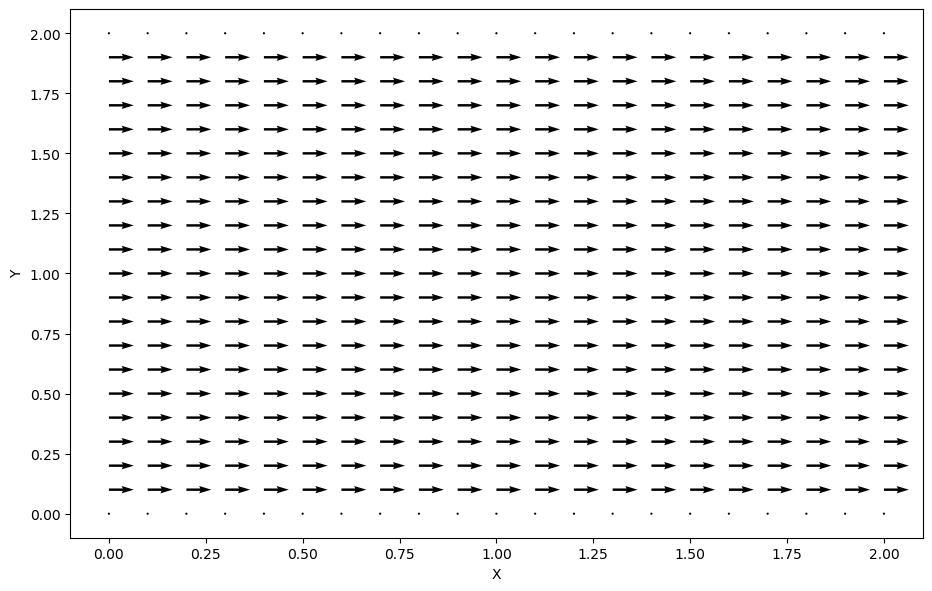

In [10]:
%time u, v, p, dx, dy, globalerror, a = chn_sim_run(1)

12541
25.082
Wall time: 2min 37s


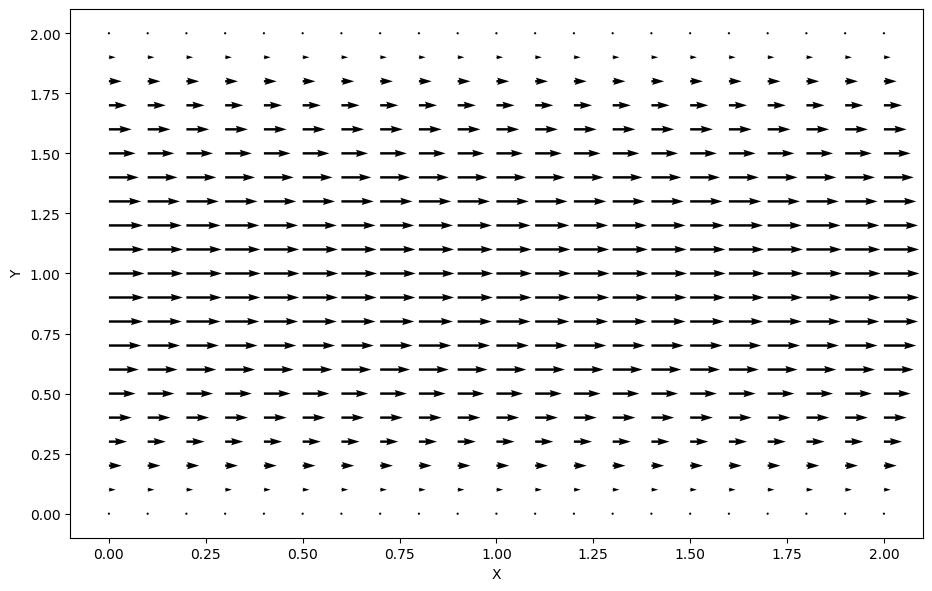

In [11]:
%time u, v, p, dx, dy, globalerror,a = chn_sim_run(1e-6)

In [12]:
dx,dy,globalerror

(0.02, 0.02, 0.002020708035642204)

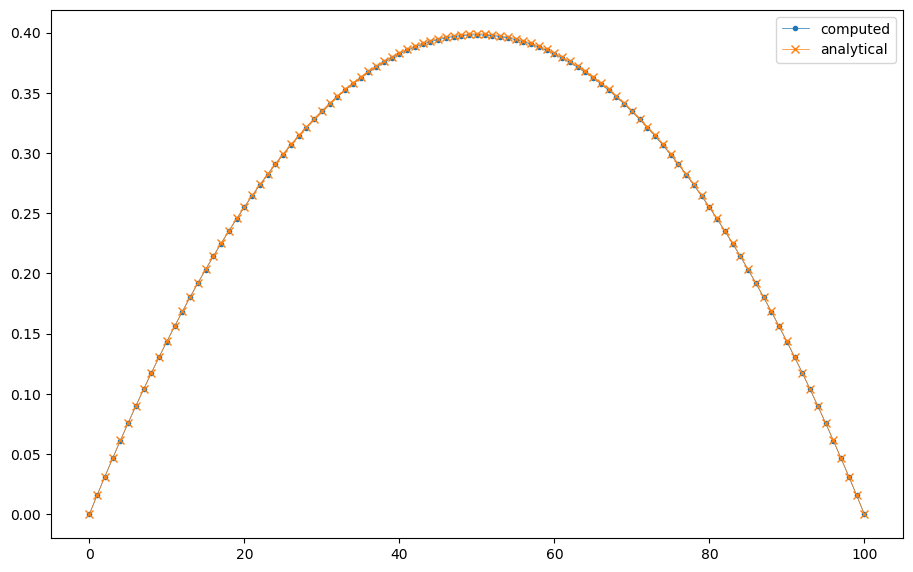

In [13]:
fig = plt.figure(figsize=(11, 7), dpi=100)
plt.plot(u[:,40], marker = '.', lw=0.5, label='computed')
plt.plot(a, marker = 'x', lw=0.5, label='analytical')
plt.legend();

In [14]:
um = np.amax(u)
Re = um * 2 / 0.1
Re

7.963113976318321